In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
import pybedtools

This notebooks aims to:
1. check for diff domain on down-regulated long DEGs
2. plot it on the heatmap
3. then check for the enhancer pairs to see if less long range enhancer after domain splitting

In [26]:
ct = 'DG_Glut'

## plot long gene expression

In [27]:
gene_meta_path = '/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
mouse_genes = pd.read_csv(gene_meta_path,sep="\t")[['chrom', 'start', 'end', 'gene_id','gene_name']]
mouse_genes['length'] = mouse_genes['end'] - mouse_genes['start']

In [28]:
deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)

In [29]:
result = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index)
result['log2(18mo/2mo)'] = np.log2(result['fc'])
result['-log10(padj)'] = -np.log10(result['fdr'])
result.head()

,fc,fdr,log2(18mo/2mo),-log10(padj)
gene,,,,
Xkr4,0.787165,9.060851e-107,-0.345262,106.042831
Gm1992,0.369641,1.208492e-01,-1.435803,0.917756
Gm19938,1.789986,1.000000e+00,0.839949,-0.000000
Mrpl15,1.012254,4.511315e-01,0.017571,0.345697
Lypla1,1.155931,8.404700e-01,0.209055,0.075478


In [30]:
sig_result = result[(result['fdr'] < 0.01) & (abs(result['log2(18mo/2mo)']) > 0.5)]
sig_result['length'] = sig_result.index.map(mouse_genes.set_index('gene_name')['length'].to_dict())

In [31]:
all_long_gene = mouse_genes[mouse_genes['length'] > 100000].shape[0]
all_degs = sig_result.shape[0]

long_gene_sig_result = sig_result[sig_result['length'] > 100000]
overlap = long_gene_sig_result.shape[0]

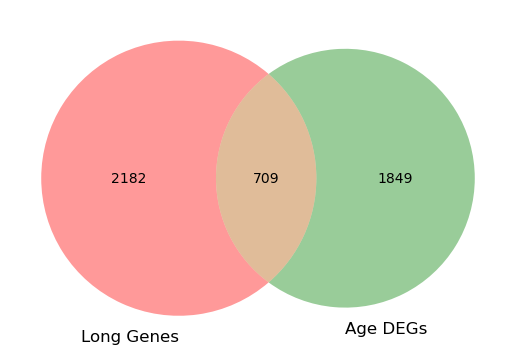

In [32]:
venn2(subsets = (all_long_gene- overlap, all_degs-overlap,overlap), set_labels = ('Long Genes', 'Age DEGs'))
plt.show()

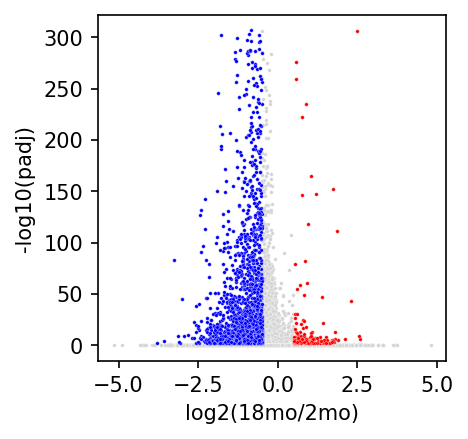

In [33]:
fig, ax = plt.subplots(figsize = (3,3), dpi = 150)
sns.scatterplot(data = result,
                ax = ax,
                color = 'lightgrey',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

sns.scatterplot(data = sig_result[sig_result['log2(18mo/2mo)'] > 0],
                ax = ax,
                color = 'red',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

sns.scatterplot(data = sig_result[sig_result['log2(18mo/2mo)'] < 0],
                ax = ax,
                color = 'blue',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

for i, row in sig_result.iterrows():
    if row['-log10(padj)'] > 100 and (row['log2(18mo/2mo)'] > 3 or row['log2(18mo/2mo)'] < -3):
        ax.text(row['log2(18mo/2mo)'], row['-log10(padj)'], 
                row.name, 
                color='black', fontsize=6)

## check those overlap with spillting domain

In [34]:
_dir = '/home/qzeng_salk_edu/project/240315-domain-split_score'
all_diff_domain = pd.read_csv(f'{_dir}/ALL.Diff.Domain.csv', index_col =0)
ct_diff_domain = all_diff_domain[all_diff_domain['celltype'] == ct]

In [35]:
ct_diff_domain =  ct_diff_domain[(ct_diff_domain['8wk'] < 0.1) & (ct_diff_domain['18mo-8wk'] > 0.05)]
binall = pd.read_csv(f'{_dir}/binall.csv', index_col =0)
ct_diff_domain =pd.concat([binall, ct_diff_domain], axis =1).dropna()
ct_diff_domain.columns = ['boudary_chr', 'boudary_start', 'boudary_end', '8wk', '9mo', '18mo', '18mo-8wk', 'celltype']
ct_diff_domain.head()

,boudary_chr,boudary_start,boudary_end,8wk,9mo,18mo,18mo-8wk,celltype
chr1_1020,chr1,25500000,25525000,0.092942,0.098532,0.144654,0.051712,DG_Glut
chr1_1690,chr1,42250000,42275000,0.056604,0.071279,0.107617,0.051013,DG_Glut
chr1_6152,chr1,153800000,153825000,0.085954,0.095737,0.138365,0.052411,DG_Glut
chr1_6370,chr1,159250000,159275000,0.076869,0.078966,0.127184,0.050314,DG_Glut
chr2_1706,chr2,42650000,42675000,0.089448,0.088749,0.151642,0.062194,DG_Glut


In [36]:
sig_long_meta = mouse_genes[mouse_genes['gene_name'].isin(long_gene_sig_result.index)].set_index('gene_name')[['chrom', 'start','end']]
long_gene_sig_result = pd.concat([sig_long_meta, long_gene_sig_result], axis = 1)
long_gene_sig_result['gene_name'] = long_gene_sig_result.index
long_gene_sig_result = long_gene_sig_result[['chrom','start','end','fc','fdr','gene_name']].copy()
long_gene_sig_result.head()

,chrom,start,end,fc,fdr,gene_name
St18,chr1,6487231,6860940,0.695524,2.377091e-114,St18
Cpa6,chr1,10324720,10719945,2.451023,9.745680e-04,Cpa6
Prex2,chr1,10993465,11303681,0.615280,2.143322e-24,Prex2
A830018L16Rik,chr1,11414105,11975901,0.652336,1.757006e-237,A830018L16Rik
Ncoa2,chr1,13139105,13374083,0.697405,7.013813e-81,Ncoa2


In [37]:
bed1 = pybedtools.BedTool.from_dataframe(ct_diff_domain)
bed2 = pybedtools.BedTool.from_dataframe(long_gene_sig_result)

intersection = bed1.intersect(bed2, wa=True, wb=True)
names = ct_diff_domain.columns.tolist() + long_gene_sig_result.columns.tolist()
intersection_df = pybedtools.BedTool.to_dataframe(intersection, names = names)

In [38]:
intersection_df

,boudary_chr,boudary_start,boudary_end,8wk,9mo,18mo,18mo-8wk,celltype,chrom,start,end,fc,fdr,gene_name
0,chr1,159250000,159275000,0.076869,0.078966,0.127184,0.050314,DG_Glut,chr1,159232320,159347640,0.553667,1.202787e-148,Cop1
1,chr10,63425000,63450000,0.085255,0.085954,0.144654,0.059399,DG_Glut,chr10,63430098,65003667,0.459872,9.494642e-16,Ctnna3
2,chr11,93100000,93125000,0.050314,0.065688,0.111111,0.060797,DG_Glut,chr11,93098028,93601749,0.588722,1.230007e-34,Car10
3,chr15,40650000,40675000,0.096436,0.099930,0.155136,0.058700,DG_Glut,chr15,40655035,41104592,0.598270,0.000000e+00,Zfpm2


## check for putative enhancers

In [198]:
example_gene = 'Aven'

In [199]:
_dir = 'ABC.By.Methylation/'
_factor = 10000000

In [200]:
gene_meta = pd.read_csv('/home/qzeng_salk_edu/project/240321_abc_score/use.mouse_genes.csv', index_col = 0)
gene_name_to_id= {v:k for k,v in gene_meta['gene_name'].to_dict().items()}

In [201]:
def genome_pos(x):
    _chr, e_start, e_end, gene_id = x.split('-')
    e_start, e_end = int(e_start), int(e_end)
    #gene_start = int(gene_meta.loc[gene_id]['start'])
    #distance = abs(e_start - gene_start)
    return e_start
    
def prepare_df(ct,age):
    tmpdf = pd.read_csv(f'{_dir}/{ct}/{ct}.{age}.abc_score.csv', index_col = 0)
    tmpdf['normalized_count'] = (tmpdf['1']/tmpdf['1'].sum())*_factor #normalization
    tmpdf = tmpdf[tmpdf['1'] >= 5] # filter for noise
    tmpdf['gene_id'] = tmpdf.index.map(lambda x: x.split('-')[-1])
    tmpdf['gene_start'] = tmpdf['gene_id'].map(gene_meta['start'].to_dict())
    tmpdf['e_start'] = tmpdf.index.map(lambda x: genome_pos(x))
    tmpdf['eg_dist'] = abs(tmpdf['e_start'] - tmpdf['gene_start'])
    return tmpdf

In [202]:
young_abc_df = prepare_df(ct, '8wk')
old_abc_df =  prepare_df(ct, '18mo')

In [203]:
young_gene_df = young_abc_df[young_abc_df['gene_id'] == gene_name_to_id[example_gene]]
old_gene_df = old_abc_df[old_abc_df['gene_id'] == gene_name_to_id[example_gene]]

In [213]:
slop = 2000
gene_start, gene_end = gene_meta[gene_meta['gene_name'] == example_gene].T.loc['start'].values[0]-slop, gene_meta[gene_meta['gene_name'] == example_gene].T.loc['end'].values[0]+slop
gene_start, gene_end

(112490964, 112636573)

In [157]:
tad_start, tad_end = 111025000, 112550000

In [154]:
#ene_meta[gene_meta['gene_name'] == example_gene]

In [156]:
## check enhancers locate in the splitted domain

In [185]:
## upstream
up_use_young = young_gene_df[(young_gene_df['e_start'] < gene_start) & (young_gene_df['e_start'] > tad_start)]
up_use_old = old_gene_df[(old_gene_df['e_start'] < gene_start) & (old_gene_df['e_start'] > tad_start)]

In [186]:
# up_use_young = young_gene_df[(young_gene_df['e_start'] < gene_start)]
# up_use_old = old_gene_df[(old_gene_df['e_start'] < gene_start)]

In [187]:
shared_e_g_pairs = list(set(use_young.index) & set(use_old.index))
shared_df = pd.concat([young_gene_df.loc[shared_e_g_pairs], old_gene_df.loc[shared_e_g_pairs]], axis = 1)
len(shared_e_g_pairs)

0

In [188]:
# ## downstream
# down_use_young = young_gene_df[(young_gene_df['e_start'] > gene_end) & (young_gene_df['e_start'] < tad_end)]
# down_use_old = old_gene_df[(old_gene_df['e_start'] > gene_end) & (old_gene_df['e_start'] < tad_end)]

# use_young = pd.concat([up_use_young, down_use_young])
# use_old = pd.concat([up_use_old, down_use_old])

In [189]:
use_young = up_use_young
use_old = up_use_old

Text(0.5, 0.98, 'Itfg1 Putative Enhancer')

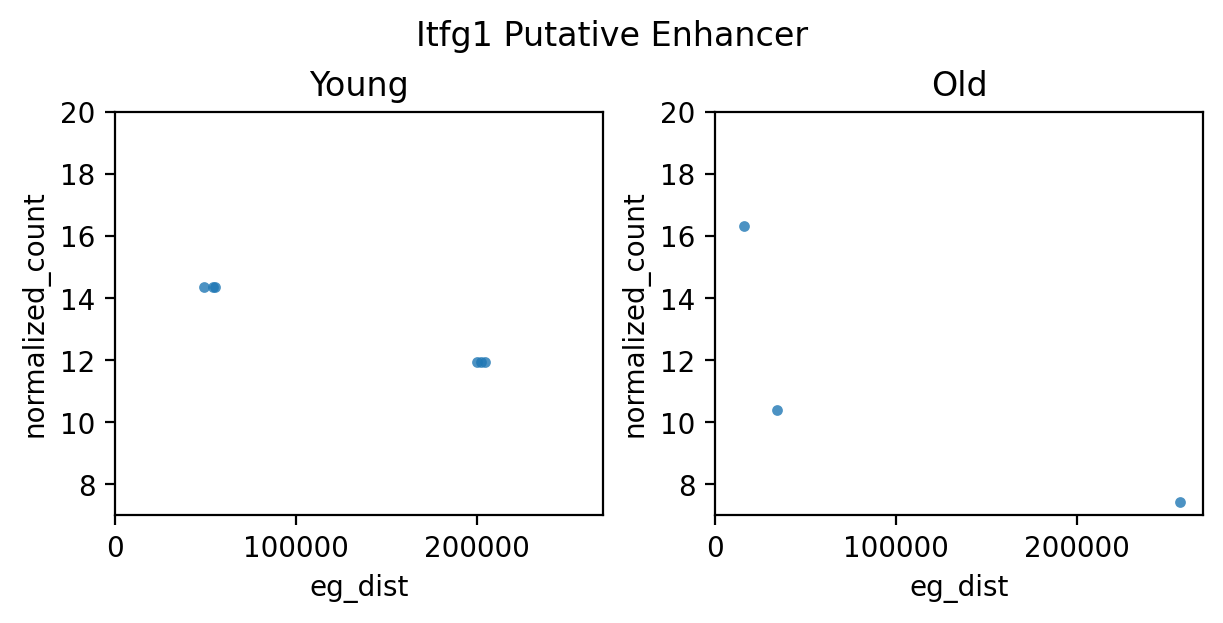

In [196]:
fig, axes= plt.subplots(figsize = (6,3), ncols = 2, dpi = 200, constrained_layout = True)

ax = axes[0]
sns.scatterplot(data = use_young, 
                x = 'eg_dist',
                y = 'normalized_count',
                alpha = 0.8,linewidth = 0,
                s =15,
                ax = ax)
ax.set_title(f"Young")
ax.set(xlim = (0,270000), ylim = (7, 20))

ax = axes[1]
sns.scatterplot(data = use_old, 
                x = 'eg_dist',
                y = 'normalized_count',
                alpha = 0.8,linewidth = 0,
                s =15,
                ax = ax)
ax.set_title(f"Old")
ax.set(xlim = (0,270000), ylim = (7, 20))

plt.suptitle(f"{example_gene} Putative Enhancer")